In [32]:
import wandb

wandb.init()

wandb: Currently logged in as: xhradskyp. Use `wandb login --relogin` to force relogin


# NETWORK

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import math
from datetime import datetime
from matplotlib import pyplot as plt
from torch.utils.data import random_split
import torchvision.transforms as transforms
from focal_loss.focal_loss import FocalLoss
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
import torchstain
from torchvision import models
from collections import Counter

## MODELS

In [46]:
net = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 7)
print(net.fc)

Linear(in_features=512, out_features=7, bias=True)


In [126]:
# Define a convolution neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 7)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

# Instantiate a neural network model 
net = Net()

In [2]:
# old
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batchmodels      
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [22]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 2)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 2)
#         self.conv3 = nn.Conv2d(16, 24, 2)
#         self.fc1 = nn.Linear(24 * 3 * 3, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 7)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

In [162]:
images = torch.randn(1, 3, 32, 32)
net(images)

torch.Size([1, 6, 14, 14])
torch.Size([1, 16, 5, 5])
torch.Size([1, 120])
torch.Size([1, 84])


tensor([[ 0.1686, -0.0594,  0.0331,  0.0879,  0.0272,  0.0455, -0.1652]],
       grad_fn=<AddmmBackward0>)

## DATASET

In [3]:
class MyDataset(Dataset):
    def __init__(self):
        images = np.load("data/images.npy")
        labels = np.load("data/labels.npy")
        
        target = images[4000]
        # color = [221, 207, 227]
        color = [187, 88, 163]
        size = 32
        image_size = 256

        T = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x*255)
        ])

        torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
        torch_normalizer.fit(T(target))
        
        max_w = 0
        max_h = 0
        
        arr_labels = []
        arr_images = []
        classes = []
        print(images.shape[0])
        print("|0123456789|")
        for n in range(images.shape[0]):
            if n % 1000 == 0:
                if n != 0:
                    print("|")
                print(n)
                print("|", end="")
            if n % 100 == 0:
                print("-", end="")
                
            individuals = np.uint8(labels[n][...,0])
            label = np.uint8(labels[n][...,1])
            image = images[n]
            new_image = image.copy()
            
            if np.size(np.unique(individuals)) == 1:
                continue
            
            # t_to_transform = T(image)            
            # image, _, _ = torch_normalizer.normalize(I=t_to_transform, stains=True)
            # image = image.detach().numpy()

            for ind in np.unique(individuals):
                if ind == 0:
                    continue
                my_img = individuals.copy()
                my_img[my_img != ind] = 0
                contours, hierarchy= cv2.findContours(my_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
                my_img = None
                # del my_img

                for i, c in enumerate(sorted_contours):
                    x,y,w,h= cv2.boundingRect(c)
                    if w > max_w:
                        max_w = w
                    if h > max_h:
                        max_h = h
                    slice_h_1 = y-(size-h)//2
                    slice_h_2 = y-(size-h)//2 + size
                    slice_w_1 = x-(size-w)//2
                    slice_w_2 = x-(size-w)//2 + size

                    cell = label[y:y+h, x:x+w]
                    ctr = Counter(cell.ravel())
                    current_class, _ = ctr.most_common(2)[0]
                    if current_class == 0:
                        current_class, _ = ctr.most_common(2)[1]

                    if(slice_h_1 < 0): 
                        slice_h_1, slice_h_2 = (0, size)
                    if(slice_w_1 < 0): 
                        slice_w_1, slice_w_2 = (0, size)
                    if(slice_h_2 > image_size): 
                        slice_h_1, slice_h_2 = (image_size-size, image_size)
                    if(slice_w_2 > image_size): 
                        slice_w_1, slice_w_2 = (image_size-size, image_size)

                    cropped_label = label[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
                    cropped_image = image[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
                    # cropped_image = image[slice_h_1 : slice_h_2, slice_w_1 : slice_w_2]
                    # new_image = None
                    # del new_image
                    
#                     c[..., 0, 0] -= slice_w_1
#                     c[..., 0, 1] -= slice_h_1
                    
#                     mask = np.zeros(cropped_label.shape, dtype=np.uint8)
#                     cv2.drawContours(mask, [c], -1, (255), cv2.FILLED)
#                     cropped_image = cv2.bitwise_and(cropped_image, cropped_image, mask=mask)
#                     black_pixels = np.where(
#                         (cropped_image[:, :, 0] == 0) & 
#                         (cropped_image[:, :, 1] == 0) & 
#                         (cropped_image[:, :, 2] == 0)
#                     )
#                     cropped_image[black_pixels] = color

                    arr_labels.append(cropped_label)
                    arr_images.append(cropped_image)
                    classes.append(current_class) 
                
                    if current_class in [1, 5]:
                        img = cropped_image
                        lb = cropped_label

                        translation_matrix = np.float32([ [1,0,4], [0,1,4] ])
                        img_translation = cv2.warpAffine(img.astype(np.uint8), translation_matrix, (32,32))
                        lb_translation = cv2.warpAffine(lb, translation_matrix, (32,32))
                        
                        mask = np.zeros(lb_translation.shape, dtype=np.uint8)
                        mask[0 == np.mean(img_translation, axis=2)] = 255
                        img_translation = cv2.inpaint(img_translation, mask, 3, cv2.INPAINT_TELEA)

                        arr_labels.append(lb_translation)
                        arr_images.append(img_translation)
                        classes.append(current_class)

                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        lb = cv2.rotate(lb, cv2.ROTATE_90_CLOCKWISE)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        lb = cv2.rotate(lb, cv2.ROTATE_90_CLOCKWISE)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.flip(img, 0)
                        lb = cv2.flip(lb, 0)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        translation_matrix = np.float32([ [1,0,-5], [0,1,-6] ])
                        img = cv2.warpAffine(img.astype(np.uint8), translation_matrix, (32, 32))
                        lb = cv2.warpAffine(lb, translation_matrix, (32, 32))
                        
                        mask = np.zeros(lb_translation.shape, dtype=np.uint8)
                        mask[0 == np.mean(img, axis=2)] = 255
                        img = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                        lb = cv2.rotate(lb, cv2.ROTATE_90_CLOCKWISE)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

                        img = cv2.flip(img, 0)
                        lb = cv2.flip(lb, 0)

                        arr_labels.append(lb)
                        arr_images.append(img)
                        classes.append(current_class)

        arr_images = np.array(arr_images)
        arr_labels = np.array(arr_labels)
        classes = np.array(classes)
        
        images = torch.tensor(arr_images)
        labels = torch.tensor(arr_labels)
        classes = torch.tensor(classes)
        
        self.images = images.permute(0, 3, 1, 2)
        self.labels = labels
        self.classes = classes
        self.max_w = max_w
        self.max_h = max_h

    def __getitem__(self, index):
        return self.images[index], self.labels[index], self.classes[index]

    def __len__(self):
        return self.images.shape[0]

In [4]:
dataset = MyDataset()

4981
|0123456789|
0
|----------|
1000
|----------|
2000
|----------|
3000
|----------|
4000
|----------

In [5]:
print(dataset[0][0].shape)
print(dataset[0][1].shape)
print(dataset[0][2])
# print(dataset[0][3].shape)
print("max_w", dataset.max_w)
print("max_h", dataset.max_h)

torch.Size([3, 32, 32])
torch.Size([32, 32])
tensor(2, dtype=torch.uint8)
max_w 91
max_h 66


In [6]:
print(len(dataset))

632570


In [7]:
hist = [0, 0, 0, 0, 0, 0, 0]
for img, lab, cl in dataset:
    hist[cl.item()] += 1

print(hist)
# old [0, 38200, 279593, 120333, 32586, 31104, 128836]

[0, 40688, 282286, 120902, 31962, 30808, 125924]


In [8]:
train_data, test_data = random_split(dataset, [500000, len(dataset)-500000])
dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

tensor(6, dtype=torch.uint8)


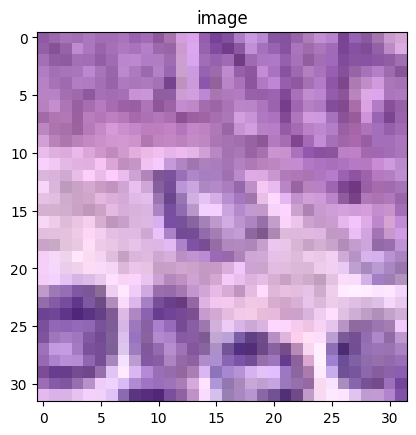

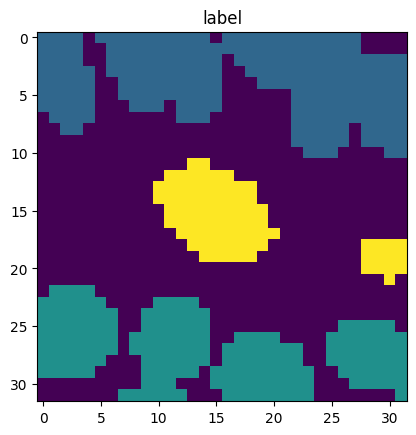

In [29]:
# classes = ['neutrophil', 'epithelial', 'lymphocyte', 'plasma', 'eosinophil', 'connective']
# classes
dataiter = iter(dataloader)
data = next(dataiter)
images, labels, classes = data
print(classes[0])
plt.imshow(images[0].permute(1, 2, 0))
plt.title("image")
plt.show()

# plt.imshow(old_images[0].permute(1, 2, 0))
# plt.title("old image")
# plt.show()

plt.imshow(labels[0])
plt.title("label")
plt.show()

# images[0]
# pred = net(images.float())
# pred[0]
# print(features.shape, labels.shape, pred.shape, pred.squeeze(1).shape)
# print(features.type(), labels.type(), pred.type(), pred.squeeze(1).type())
# loss_fn(pred.squeeze(1), classes)

## TRAINING

In [30]:
num_epochs = 20
total_samples = len(train_data)
n_iterations = math.ceil(total_samples/32)
print(total_samples, n_iterations)
net = Net()
# loss_fn = nn.CrossEntropyLoss()
# loss_fn = FocalLoss(gamma=0.7)
# m = torch.nn.Softmax(dim=-1)
loss_fn = nn.NLLLoss()
# loss_fn = nn.KLDivLoss()
# opt = torch.optim.Adam(net.parameters(), lr=0.001)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

500000 15625


In [33]:
start_time = datetime.now()
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, labels, classes) in enumerate(dataloader):
        opt.zero_grad()
        outputs = net(inputs.float())
        outputs = F.log_softmax(outputs, dim=1)
        loss = loss_fn(outputs, classes)
        loss.backward()
        opt.step()
        wandb.log({"loss_6": loss})
        # forward, backwards, update
        running_loss += loss.item()
        if (i+1) % 1000 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_iterations}, loss {running_loss / 1000}, time {(datetime.now()-start_time)}')
            running_loss = 0

epoch 1/20, step 1000/15625, loss 1.34702451390028, time 0:00:07.628782
epoch 1/20, step 2000/15625, loss 1.1821939694285393, time 0:00:14.154833
epoch 1/20, step 3000/15625, loss 1.1094731193184852, time 0:00:20.789285
epoch 1/20, step 4000/15625, loss 1.0642770544886588, time 0:00:28.119674
epoch 1/20, step 5000/15625, loss 1.0400098565220832, time 0:00:34.603565
epoch 1/20, step 6000/15625, loss 1.0190966254472733, time 0:00:41.051426
epoch 1/20, step 7000/15625, loss 0.9971454317867756, time 0:00:47.426739
epoch 1/20, step 8000/15625, loss 0.9820088750720024, time 0:00:53.863503
epoch 1/20, step 9000/15625, loss 0.9622741715610027, time 0:01:00.338755
epoch 1/20, step 10000/15625, loss 0.9580874129533767, time 0:01:06.796641
epoch 1/20, step 11000/15625, loss 0.9605089708268643, time 0:01:13.828888
epoch 1/20, step 12000/15625, loss 0.9669305340349674, time 0:01:21.039848
epoch 1/20, step 13000/15625, loss 0.9440200816988945, time 0:01:28.393943
epoch 1/20, step 14000/15625, loss 0

KeyboardInterrupt: 

In [ ]:
torch.save(net, "net_g_cell_crop_9")

In [34]:
net = Net()
net = torch.load("net_g_cell_crop_3")

## VALIDATING

In [34]:
dataloader_test = DataLoader(dataset=test_data, batch_size=32, shuffle=True)
dataiter = iter(dataloader)

pred 2
truth 2


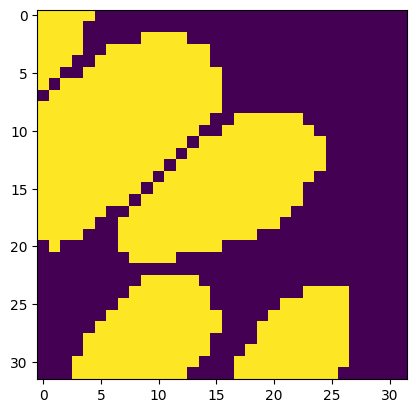

In [43]:
data = next(dataiter)
images, labels, classes = data
with torch.no_grad():
    outputs = net(images.float())
    # print(outputs[0])
    print(f'pred {np.where(outputs[0] == outputs[0].max())[0][0]}')
    print(f'truth {classes[0].item()}')
    # print(f'truth {np.where(classes[0] == classes[0].max())[0][0]}')
    plt.imshow(labels[0].detach().numpy())
    plt.show()

In [ ]:
total_samples = len(test_data)
n_iterations = math.ceil(total_samples/32)
correct = 0
total = 0
confusion_matrix = np.zeros((6, 6), dtype=np.uint8)
confusion_matrix_images = np.zeros((6, 6, 3, 32, 32), dtype=np.uint8)
total_predictions = np.zeros(6, dtype=np.uint8)
total_classes = np.zeros(6, dtype=np.uint8)
img_count = 0
with torch.no_grad():
    for i, (inputs, labels, classes) in enumerate(dataloader_test):
        outputs = net(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        total += classes.size(0)
        correct += (predicted == classes).sum().item()
        # [confusion_matrix[pr-1, cl-1] += 1 for i in zip(predicted, classes)]
        for j, (pr, cl) in enumerate(zip(predicted, classes)):
            confusion_matrix[pr.item()-1, cl.item()-1] += 1
            total_predictions[pr.item()-1] += 1
            total_classes[cl.item()-1] += 1
#             if np.sum(confusion_matrix_images[pr.item()-1, cl.item()-1]) == 0:
#                 confusion_matrix_images[pr.item()-1, cl.item()-1] = inputs[j]
                
# #                 im = Image.fromarray(inputs[j].detach().numpy().astype(np.uint8).transpose(1, 2, 0))
# #                 im.save(f"vis/cropped-norm-{img_count}.png")
                
# #                 im = Image.fromarray(old_images[j].detach().numpy().astype(np.uint8).transpose(1, 2, 0))
# #                 im.save(f"vis/cropped-old-{img_count}.png")
                
#                 img_count += 1
        if (i+1) % 500 == 0:
            print(f'step {i+1} / {n_iterations}')

print(f'Accuracy of the network on {total} test images: {(correct / total) * 100:.2f} %')

In [74]:
fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
i = 1
for row in range(rows):
    for column in range(columns):
        img = confusion_matrix_images[row, column].transpose(1, 2, 0)
        # fig.add_subplot(rows, columns, i)
        # plt.imshow(img)
        i+=1
# plt.show()

<Figure size 800x800 with 0 Axes>

In [61]:
print("predictions count: ", total_predictions)
print("classes count:     ", total_classes)

predictions count:  [224 172  85  39 124 252]
classes count:      [211  74 157 175 137 142]


In [62]:
confusion_matrix
#   g r o u n d  t h r u t h
# p
# r
# e
# d
# i
# c
# t

array([[107,  19,  25,   9,  40,  24],
       [ 17,  35,  30,   4,   5,  81],
       [ 28,  65,  24, 110,  19,  95],
       [  0,   3,  11,  19,   0,   6],
       [ 23,   8,  12,   4,  65,  12],
       [ 36, 200,  55,  29,   8, 180]], dtype=uint8)

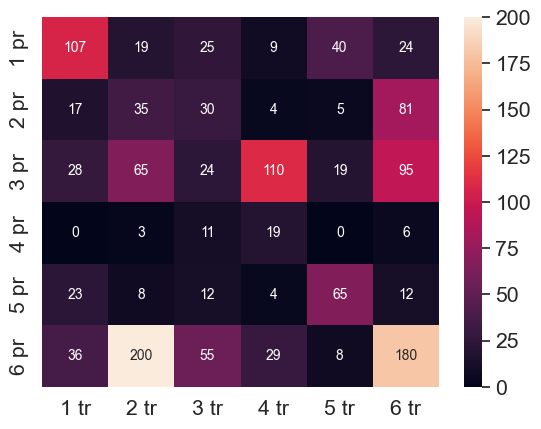

In [63]:
df = pd.DataFrame(confusion_matrix, [str(i) + " pr" for i in range(1,7)], [str(i) + " tr" for i in range(1,7)])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 10}, fmt='g') # font size

plt.show()

# RESULTS

## 2 layers, without augmentation, net_cell_crop_1

Accuracy of the network on 53921 test images: 68.08 %

classes: [18457, 3539, 150346, 56178, 16374, 2905, 106122]

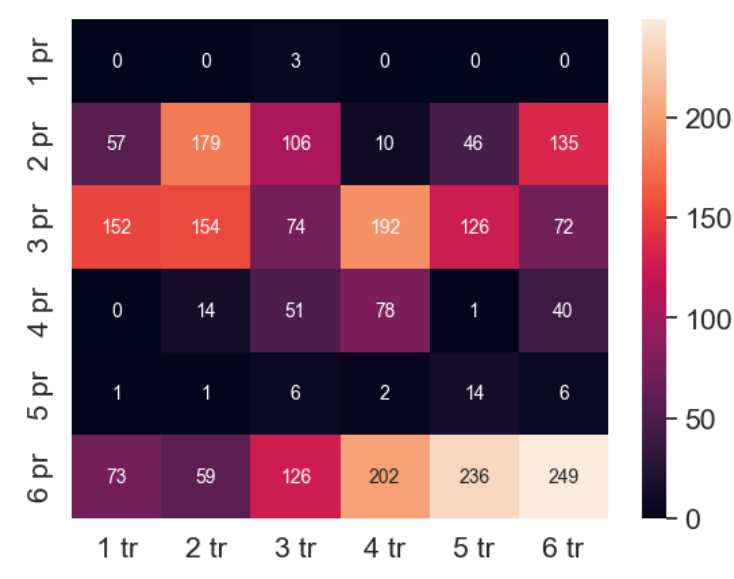

---

## 2 layers, with (7) augmentation on classes 1 and 5, net_cell_crop_2

Accuracy of the network on 59029 test images: 66.39 %

classes: [18457, 28312, 150346, 56178, 16374, 23240, 106122]

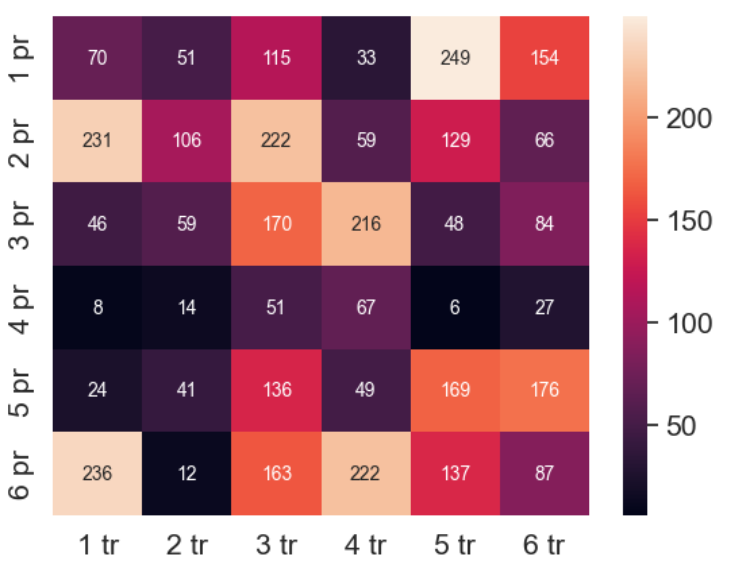

---

## 2 layers, with (7) augmentation on classes 1 and 5, better anotated dataset, net_g_cell_crop_1

Accuracy of the network on 130652 test images: 75.97 %

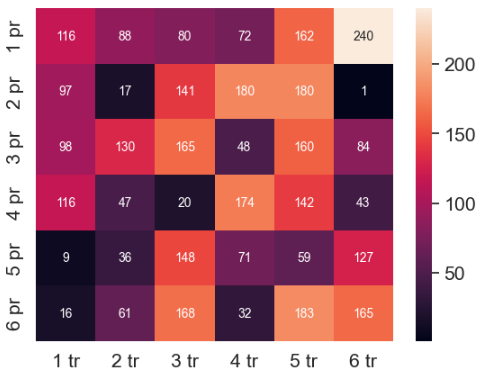

---

## 3 layers, with (7) augmentation on classes 1 and 5, better anotated dataset, net_g_cell_crop_2

Accuracy of the network on 130652 test images: 70.80 %

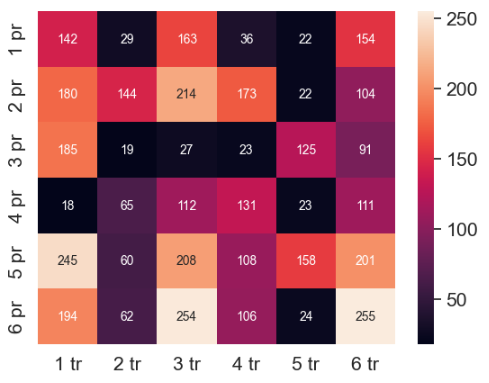

---

## 2 layers, with aug, size 64 -> BAD

Accuracy of the network on 130652 test images: 41.54 %

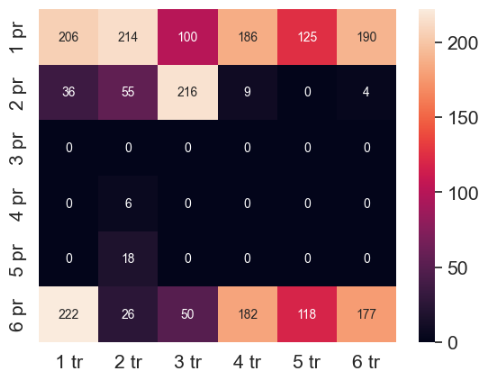

---

## 2 layers, with aug, with norm, net_g_cell_crop_3

Accuracy of the network on 130652 test images: 67.15 %

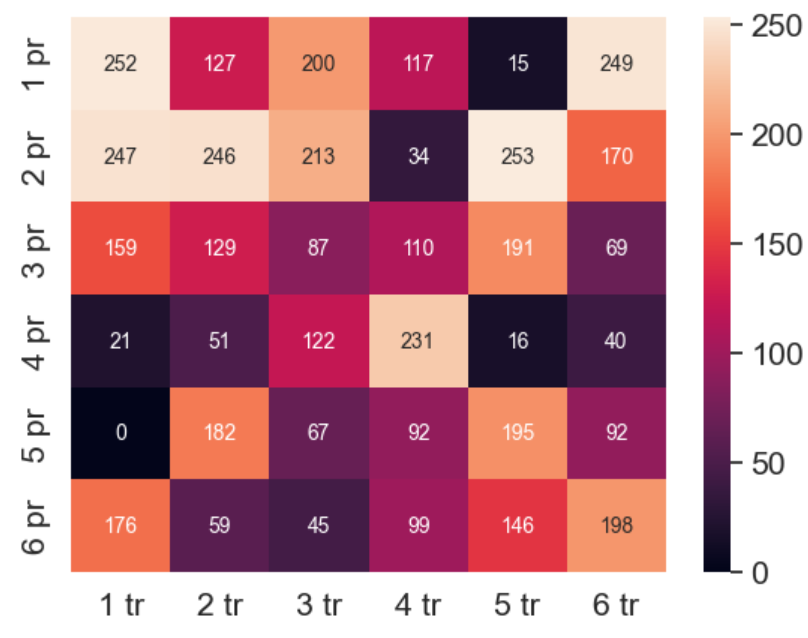

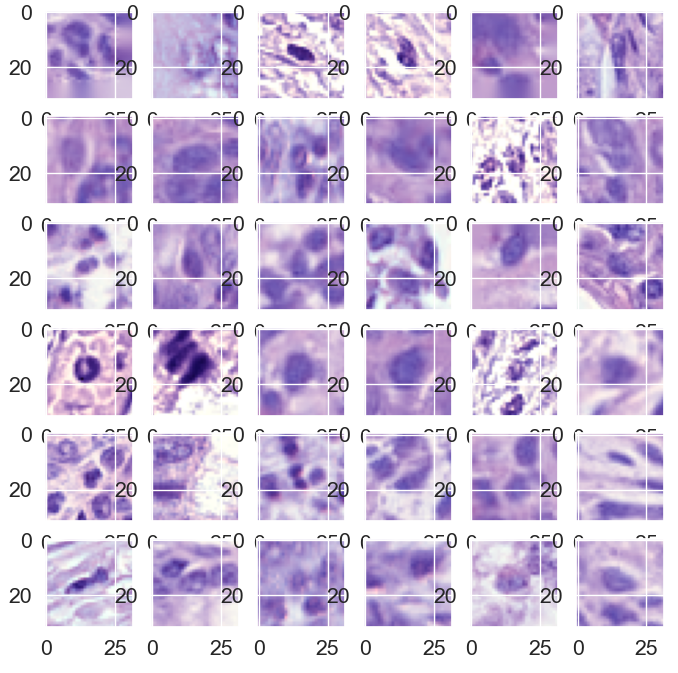

---

## 2 layers, 10 epochs, with aug, with norm, with cut outs, net_g_cell_crop_4

Accuracy of the network on 130652 test images: 64.59 %

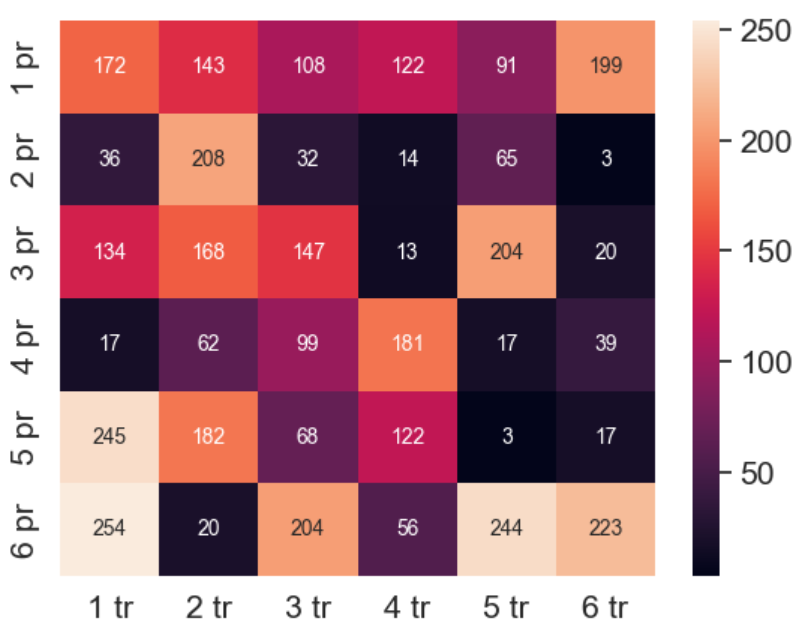

---

## 5 layers, 10 epochs, with aug, net_g_cell_crop_6

Accuracy of the network on 130652 test images: 78.75 %

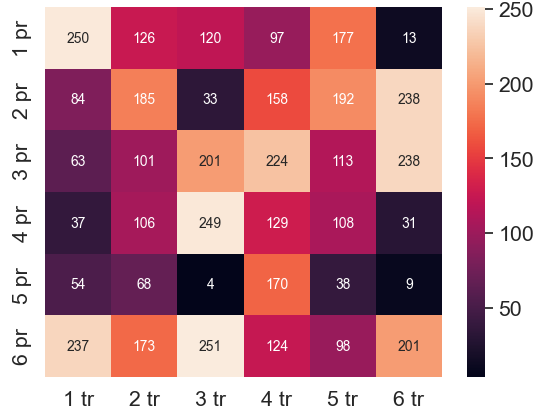